In [1]:
import sys
sys.path.insert(0, '..')

%load_ext tools.prov_magics
import tools.view.prov_dictionary

# PROV Dictionary

## Names, literals, and constants

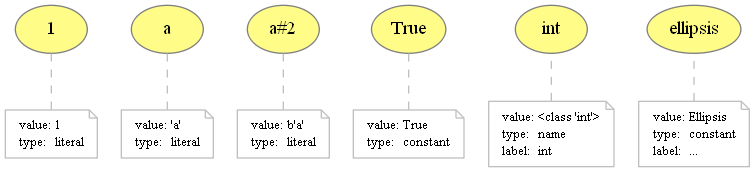

In [2]:
%%provn -o ../images/prov_dictionary/names -e png svg pdf provn
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>

entity(1, [value="1", type="script:literal"])
entity(a, [value="'a'", type="script:literal"])
entity(a#2, [value="b'a'", type="script:literal"])
entity(True, [value="True", type="script:constant"])
entity(int, [value="<class 'int'>", type="script:name", label="int"])
entity(ellipsis, [value="Ellipsis", type="script:constant", label="..."])

## Assignment

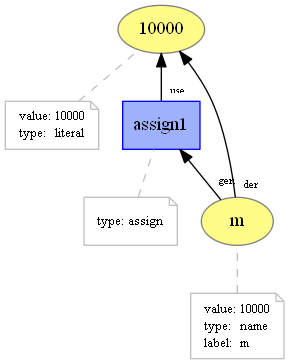

In [3]:
%%provn -o ../images/prov_dictionary/assign -e png svg pdf provn
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>

entity(10000, [value="10000", type="script:literal"])
entity(m, [value="10000", type="script:name", label="m"])

activity(assign1, [type="script:assign"])
used(u1; assign1, 10000, -)
wasGeneratedBy(g1; m, assign1, -)
wasDerivedFrom(m, 10000, assign1, g1, u1)

## Operation

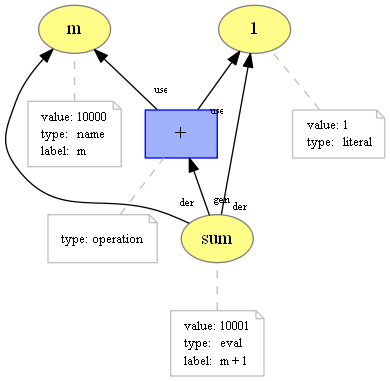

In [4]:
%%provn -o ../images/prov_dictionary/operation -e png svg pdf provn
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>

// old
entity(m, [value="10000", type="script:name", label="m"])

// new
entity(1, [value="1", type="script:literal"])
entity(sum, [value="10001", type="eval", label="m + 1"])

activity(+, [type="script:operation"])
used(u2; +, m, -)
used(u3; +, 1, -)
wasGeneratedBy(g2; sum, +, -)
wasDerivedFrom(sum, m, +, g2, u2)
wasDerivedFrom(sum, 1, +, g3, u3)

## List definition

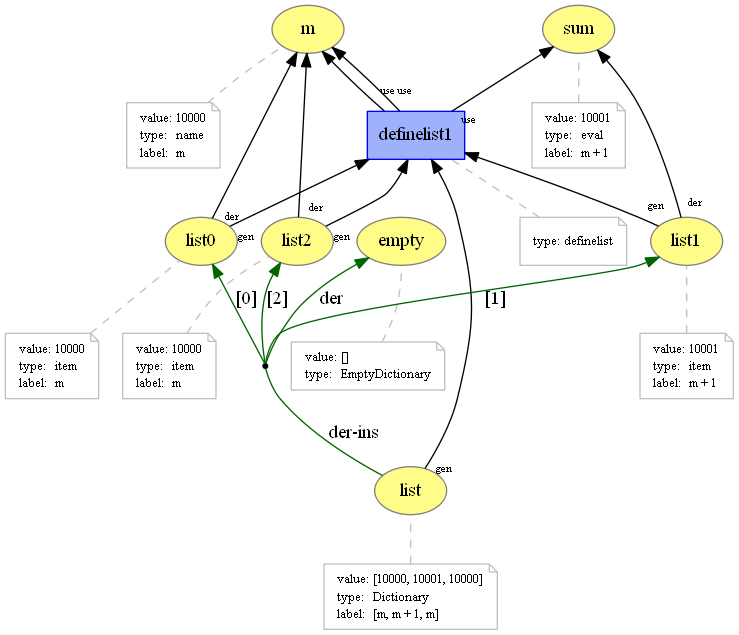

In [12]:
%%provn -o ../images/prov_dictionary/list -e png svg pdf provn
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>

// old
entity(m, [value="10000", type="script:name", label="m"])
entity(sum, [value="10001", type="script:eval", label="m + 1"])

// new
entity(empty, [value="[]", type="EmptyDictionary"])
entity(list, [value="[10000, 10001, 10000]", type="Dictionary", label="[m, m + 1, m]"])
entity(list0, [value="10000", type="script:item", label="m"])
entity(list1, [value="10001", type="script:item", label="m + 1"])
entity(list2, [value="10000", type="script:item", label="m"])
derivedByInsertionFrom(
    list, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)

activity(definelist1, [type="script:definelist"])
used(u4; definelist1, m, -)
wasGeneratedBy(g4; list0, definelist1, -)
wasDerivedFrom(list0, m, definelist1, g4, u4)
used(u5; definelist1, sum, -)
wasGeneratedBy(g5; list1, definelist1, -)
wasDerivedFrom(list1, sum, definelist1, g5, u5)
used(u6; definelist1, m, -)
wasGeneratedBy(g6; list2, definelist1, -)
wasDerivedFrom(list2, m, definelist1, g6, u6)
wasGeneratedBy(list, definelist1, -)

## Assignment of list definition

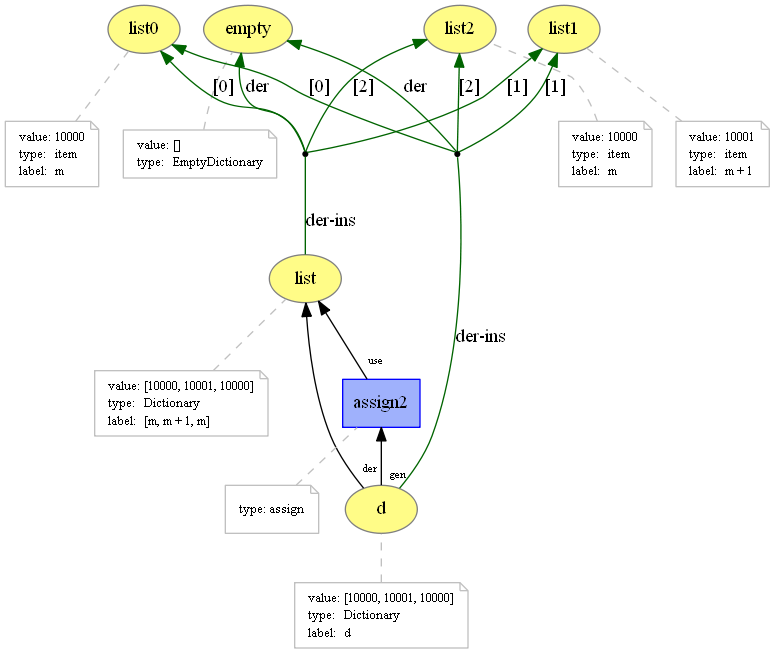

In [13]:
%%provn -o ../images/prov_dictionary/list_assign -e png svg pdf provn
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
    
// old
entity(empty, [value="[]", type="EmptyDictionary"])
entity(list, [value="[10000, 10001, 10000]", type="Dictionary", label="[m, m + 1, m]"])
entity(list0, [value="10000", type="script:item", label="m"])
entity(list1, [value="10001", type="script:item", label="m + 1"])
entity(list2, [value="10000", type="script:item", label="m"])
derivedByInsertionFrom(
    list, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)

// new
entity(d, [value="[10000, 10001, 10000]", type="Dictionary", label="d"])
derivedByInsertionFrom(
    d, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)

activity(assign2, [type="script:assign"])
used(u7; assign2, list, -)
wasGeneratedBy(g7; d, assign2, -)
wasDerivedFrom(d, list, assign2, g7, u7)

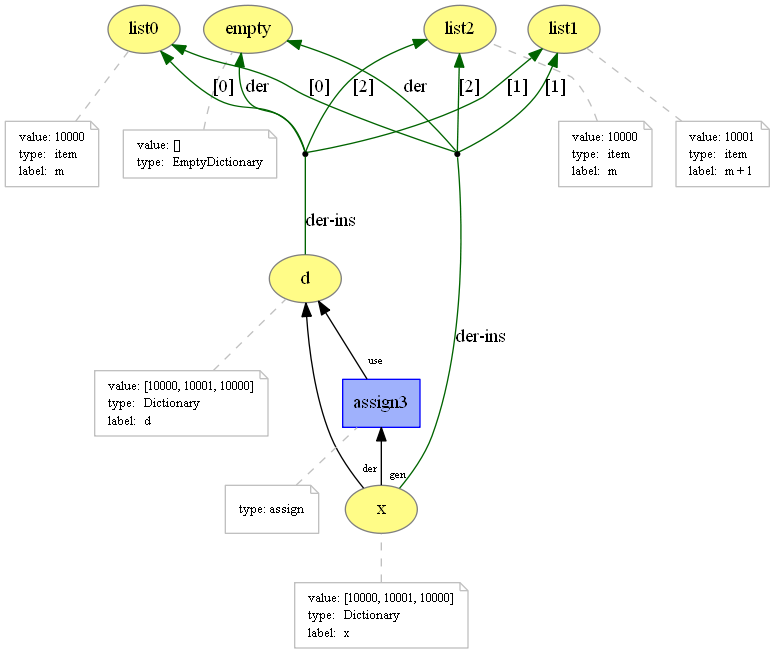

In [14]:
%%provn -o ../images/prov_dictionary/list_assign2 -e png svg pdf provn
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>

// old
entity(empty, [value="[]", type="EmptyDictionary"])
entity(d, [value="[10000, 10001, 10000]", type="Dictionary", label="d"])
entity(list0, [value="10000", type="script:item", label="m"])
entity(list1, [value="10001", type="script:item", label="m + 1"])
entity(list2, [value="10000", type="script:item", label="m"])
derivedByInsertionFrom(
    d, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)

// new
entity(x, [value="[10000, 10001, 10000]", type="Dictionary", label="x"])
derivedByInsertionFrom(
    x, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)

activity(assign3, [type="script:assign"])
used(u8; assign3, d, -)
wasGeneratedBy(g8; x, assign3, -)
wasDerivedFrom(x, d, assign3, g8, u8)

## Function call

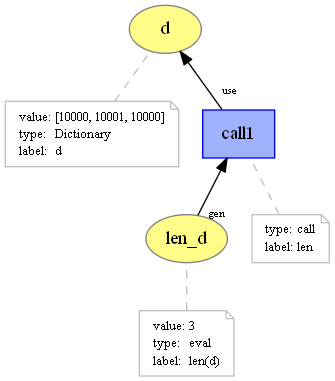

In [8]:
%%provn -o ../images/prov_dictionary/call -e png svg pdf provn
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>

// old
entity(d, [value="[10000, 10001, 10000]", type="Dictionary", label="d"])

// new
entity(len_d, [value="3", type="script:eval", label="len(d)"])

activity(call1, [type="script:call", label="len"])
used(call1, d, -)
wasGeneratedBy(len_d, call1, -)

## Access to part of structure

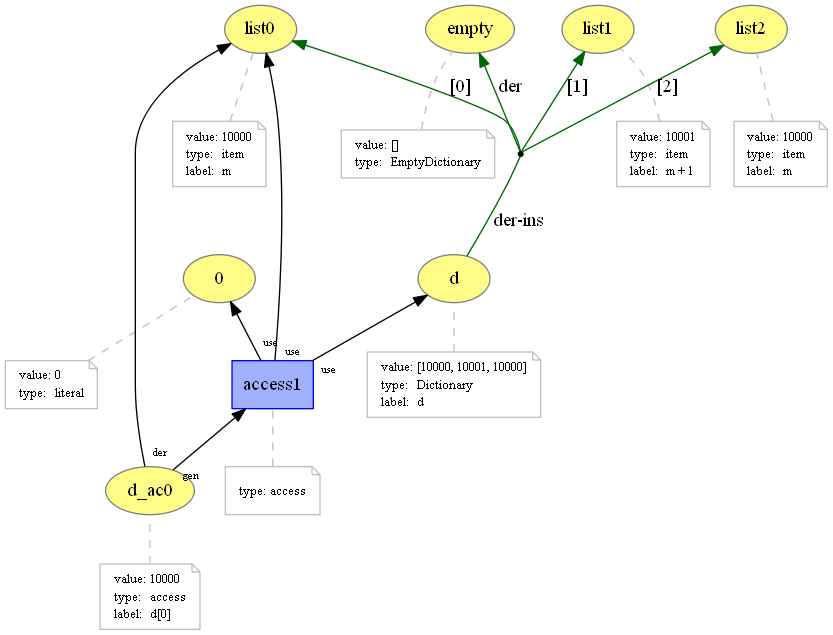

In [15]:
%%provn -o ../images/prov_dictionary/access -e png svg pdf provn
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>

// old
entity(empty, [value="[]", type="EmptyDictionary"])
entity(list0, [value="10000", type="script:item", label="m"])
entity(list1, [value="10001", type="script:item", label="m + 1"])
entity(list2, [value="10000", type="script:item", label="m"])
entity(d, [value="[10000, 10001, 10000]", type="Dictionary", label="d"])
derivedByInsertionFrom(
    d, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)


// new
entity(0, [value="0", type="script:literal"])
entity(d_ac0, [value="10000", type="script:access", label="d[0]"])

activity(access1, [type="script:access"])
used(access1, d, -)
used(access1, 0, -)
used(u9; access1, list0, -)
wasGeneratedBy(g9; d_ac0, access1, -)
wasDerivedFrom(d_ac0, list0, access1, g9, u9)

## Assignment to part of structure

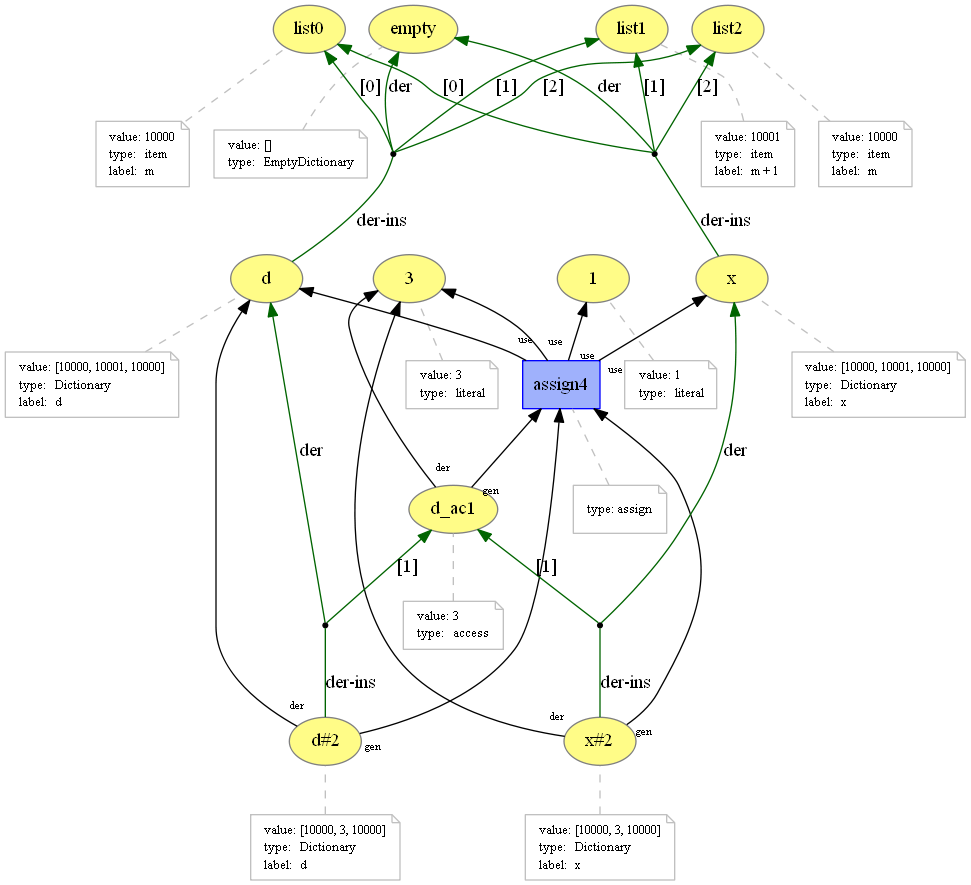

In [18]:
%%provn -o ../images/prov_dictionary/part_assign -e png svg pdf provn
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
    
// old
entity(empty, [value="[]", type="EmptyDictionary"])
entity(list0, [value="10000", type="script:item", label="m"])
entity(list1, [value="10001", type="script:item", label="m + 1"])
entity(list2, [value="10000", type="script:item", label="m"])
entity(d, [value="[10000, 10001, 10000]", type="Dictionary", label="d"])
derivedByInsertionFrom(
    d, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)

entity(x, [value="[10000, 10001, 10000]", type="Dictionary", label="x"])
derivedByInsertionFrom(
    x, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)
entity(1, [value="1", type="script:literal"])

// new
entity(3, [value="3", type="script:literal"])
entity(d_ac1, [value="3", type="script:access"])
entity(d#2, [value="[10000, 3, 10000]", type="Dictionary", label="d"])
entity(x#2, [value="[10000, 3, 10000]", type="Dictionary", label="x"])

activity(assign4, [type="script:assign"])
used(assign4, 1, -)
used(u10; assign4, 3, -)
wasGeneratedBy(g10; d_ac1, assign4, -)
wasDerivedFrom(d_ac1, 3, assign4, g10, u10)

used(u11; assign4, d, -)
wasGeneratedBy(g11; d#2, assign4, -)
wasDerivedFrom(d#2, d, assign4, g11, u11)
derivedByInsertionFrom(d#2, d, {("1", d_ac1)})

used(u12; assign4, x, -)
wasGeneratedBy(g12; x#2, assign4, -)
wasDerivedFrom(x#2, 3, assign4, g12, u12)
derivedByInsertionFrom(x#2, x, {("1", d_ac1)})


## Full

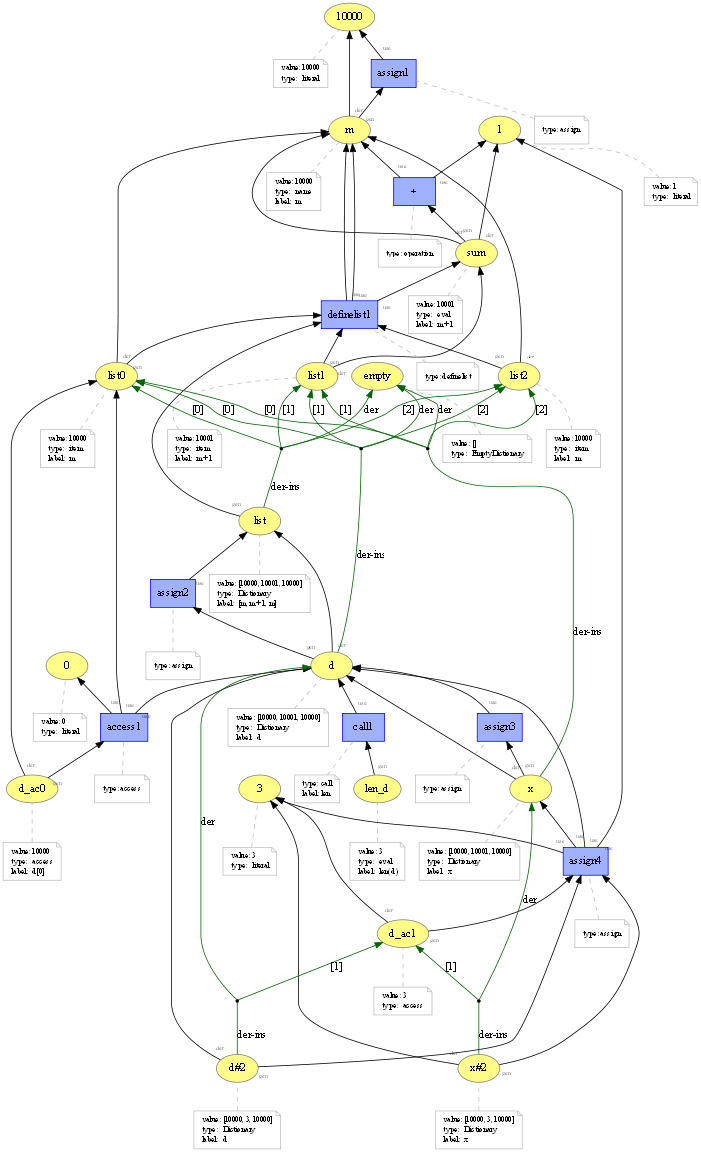

In [19]:
%%provn -o ../images/prov_dictionary/full -e png svg pdf provn
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>

// assignment
entity(10000, [value="10000", type="script:literal"])
entity(m, [value="10000", type="script:name", label="m"])

activity(assign1, [type="script:assign"])
used(u1; assign1, 10000, -)
wasGeneratedBy(g1; m, assign1, -)
wasDerivedFrom(m, 10000, assign1, g1, u1)

// operation
entity(1, [value="1", type="script:literal"])
entity(sum, [value="10001", type="script:eval", label="m + 1"])

activity(+, [type="script:operation"])
used(u2; +, m, -)
used(u3; +, 1, -)
wasGeneratedBy(g2; sum, +, -)
wasDerivedFrom(sum, m, +, g2, u2)
wasDerivedFrom(sum, 1, +, g3, u3)

// list definition
entity(empty, [value="[]", type="EmptyDictionary"])
entity(list, [value="[10000, 10001, 10000]", type="Dictionary", label="[m, m + 1, m]"])
entity(list0, [value="10000", type="script:item", label="m"])
entity(list1, [value="10001", type="script:item", label="m + 1"])
entity(list2, [value="10000", type="script:item", label="m"])
derivedByInsertionFrom(
    list, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)

activity(definelist1, [type="script:definelist"])
used(u4; definelist1, m, -)
wasGeneratedBy(g4; list0, definelist1, -)
wasDerivedFrom(list0, m, definelist1, g4, u4)
used(u5; definelist1, sum, -)
wasGeneratedBy(g5; list1, definelist1, -)
wasDerivedFrom(list1, sum, definelist1, g5, u5)
used(u6; definelist1, m, -)
wasGeneratedBy(g6; list2, definelist1, -)
wasDerivedFrom(list2, m, definelist1, g6, u6)
wasGeneratedBy(list, definelist1, -)

// list assignment
entity(d, [value="[10000, 10001, 10000]", type="Dictionary", label="d"])
derivedByInsertionFrom(
    d, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)

activity(assign2, [type="script:assign"])
used(u7; assign2, list, -)
wasGeneratedBy(g7; d, assign2, -)
wasDerivedFrom(d, list, assign2, g7, u7)

// list assignment 2
entity(x, [value="[10000, 10001, 10000]", type="Dictionary", label="x"])
derivedByInsertionFrom(
    x, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)

activity(assign3, [type="script:assign"])
used(u8; assign3, d, -)
wasGeneratedBy(g8; x, assign3, -)
wasDerivedFrom(x, d, assign3, g8, u8)

// call
entity(len_d, [value="3", type="script:eval", label="len(d)"])

activity(call1, [type="script:call", label="len"])
used(call1, d, -)
wasGeneratedBy(len_d, call1, -)

// part access
entity(0, [value="0", type="script:literal"])
entity(d_ac0, [value="10000", type="script:access", label="d[0]"])

activity(access1, [type="script:access"])
used(access1, d, -)
used(access1, 0, -)
used(u9; access1, list0, -)
wasGeneratedBy(g9; d_ac0, access1, -)
wasDerivedFrom(d_ac0, list0, access1, g9, u9)

// part assignment
entity(3, [value="3", type="script:literal"])
entity(d_ac1, [value="3", type="script:access"])
entity(d#2, [value="[10000, 3, 10000]", type="Dictionary", label="d"])
entity(x#2, [value="[10000, 3, 10000]", type="Dictionary", label="x"])

activity(assign4, [type="script:assign"])
used(assign4, 1, -)
used(u10; assign4, 3, -)
wasGeneratedBy(g10; d_ac1, assign4, -)
wasDerivedFrom(d_ac1, 3, assign4, g10, u10)

used(u11; assign4, d, -)
wasGeneratedBy(g11; d#2, assign4, -)
wasDerivedFrom(d#2, d, assign4, g11, u11)
derivedByInsertionFrom(d#2, d, {("1", d_ac1)})

used(u12; assign4, x, -)
wasGeneratedBy(g12; x#2, assign4, -)
wasDerivedFrom(x#2, 3, assign4, g12, u12)
derivedByInsertionFrom(x#2, x, {("1", d_ac1)})

